In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv


In [2]:
data = pd.read_csv('/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


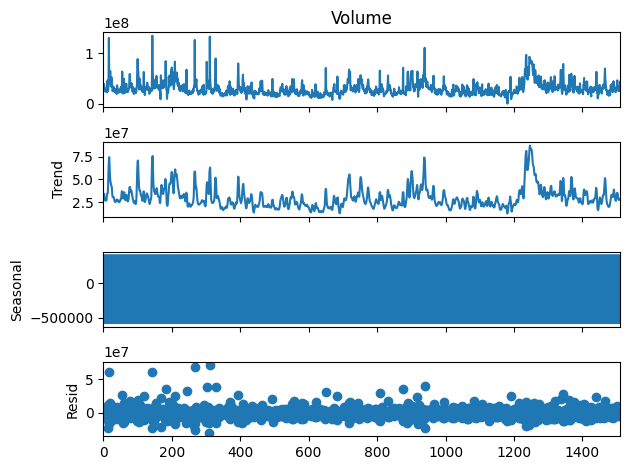

In [3]:
#decomposing a time series
import statsmodels.api as sm
import matplotlib.pyplot as plt

decomposition = sm.tsa.seasonal_decompose(data['Volume'],model='additive', period=4)
decomposition.plot()
plt.show()

The Trend component shows the long-term movement of trading volume over time. In the plot, we can see whether trading activity is generally increasing, decreasing or staying stable over the observed period.
The Seasonal component represents repeating, regular fluctuations that occur within each 4-period cycle, seasonality might reflect short-term periodic spikes in trading activity.
The Residual component captures irregular variations not explained by trend or seasonality.

Calculate moving average: moving average smooths out short-term fluctuations in our time series by averaging data points over a fixed window.

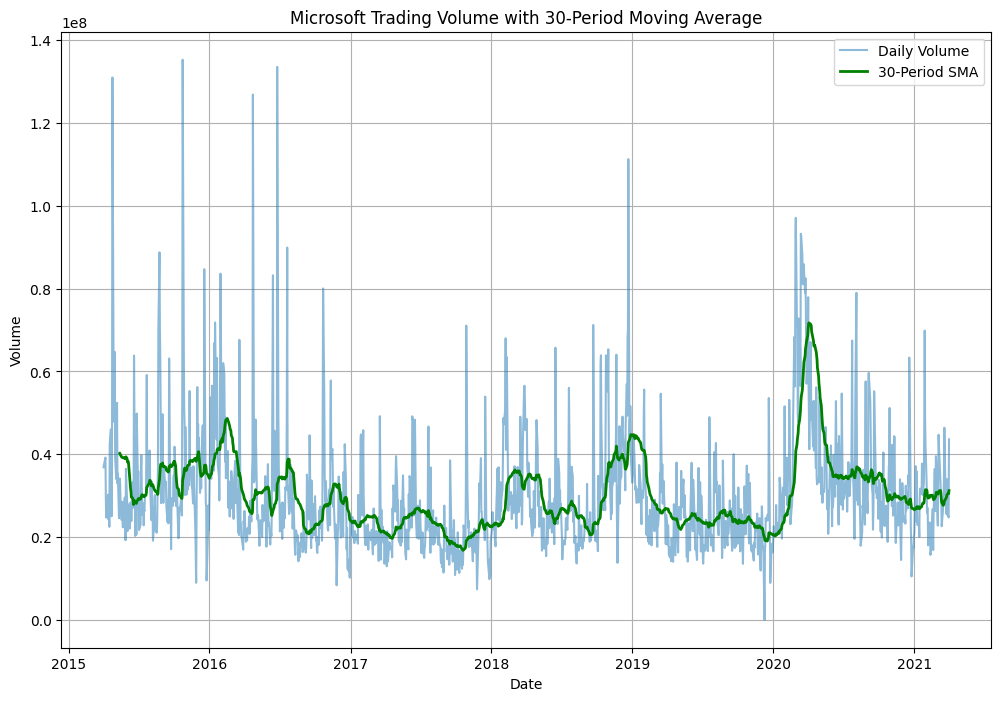

In [4]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort in case it's not in chronological order
data = data.sort_values('Date')

# Calculate a 30-period Simple Moving Average(SMA)
data['SMA_30'] = data['Volume'].rolling(window=30).mean()

# Plot
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['Volume'], label='Daily Volume', alpha=0.5)
plt.plot(data['Date'], data['SMA_30'], label='30-Period SMA', color='green', linewidth=2)

plt.title('Microsoft Trading Volume with 30-Period Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


The blue line plots daily volume, revealing sharp fluctuations with several spikes in activity.
The green line corresponds to the 30-period moving average, providing a more stable and continuous view of the overall trend.
This helps detect periods of high market activity, and Track underlying trends by smoothing out daily fluctuations, and Assist in investment decision-making or technical analysis.

High peaks visible on the chart indicate days of high activity. This may correspond to financial results releases (earnings reports), strategic announcements (acquisitions, product launches), and
macroeconomic events or regulatory changes.
These peaks are often accompanied by sharp price fluctuations, which may signal increased volatility.

The green line smooths out daily fluctuations to reveal the overall trend in volume.
A gradual rise in the SMA may indicate growing investor interest.
Conversely, a prolonged decline suggests a decline in activity, potentially related to a period of waiting or market consolidation.

We see high volume with a sharp SMA rise, which often indicates a strong signal: investors are reacting to important news.

Checking stationarity and perform differencing.
Stationarity means the statistical properties of the series(mean, variance, autocorrelation) don't change over time. 

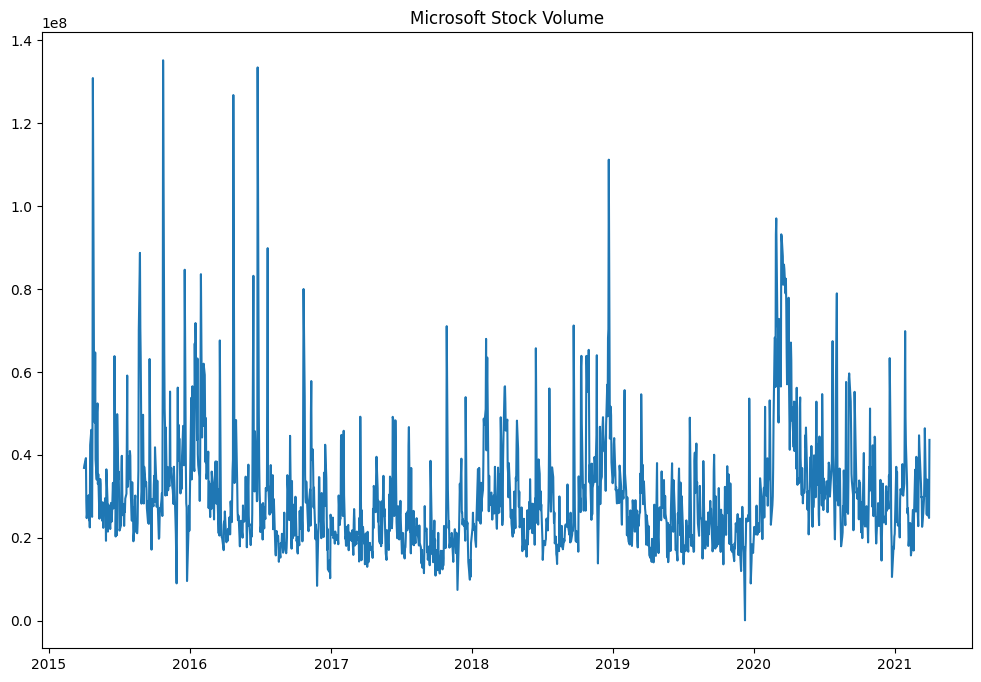

In [5]:
#Check stationarity (visualizing inspection: if we see a trend or changing variance, it's likely non-stationarity)

plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['Volume'])
plt.title('Microsoft Stock Volume')
plt.show()


We see the data we are using is quite stationary, still here’s how to check stationarity and perform differencing to achieve stationarity.

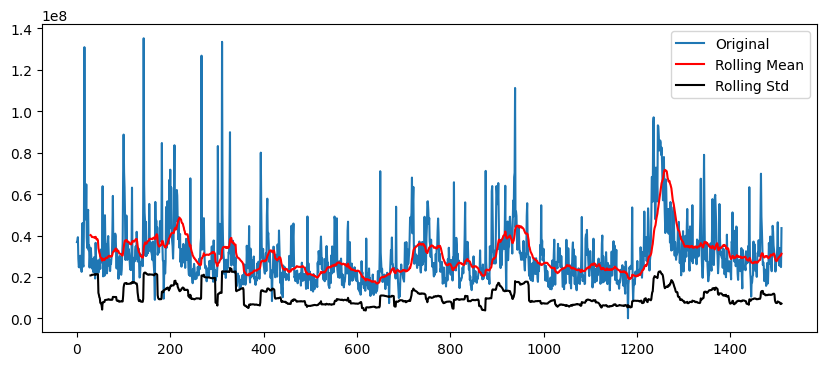

In [6]:
rolling_mean = data['Volume'].rolling(window=30).mean()
rolling_std = data['Volume'].rolling(window=30).std()

plt.figure(figsize=(10,4))
plt.plot(data['Volume'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(data['Volume'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -6.899655612142819
p-value: 1.2918117349076232e-09
Critical Value 1%: -3.4347111923936393
Critical Value 5%: -2.863466189518188
Critical Value 10%: -2.5677954794761004


this output means our microsoft stock trading volume series is already stationarity:
ADF Statistic = -6.8996, more negative than all critical values(1%, 5%, 10%).
p-value = 1.29*10e-9, far below (0.05) reject the null hypothesis of non-stationarity.
Conclusion: the mean and the variance are already stable over time.

Now we show a quick ARIMAgrid search for our stationary series to pick the best p,d,q automatically. Our series is already stationary(d=0), we'll search for the best p and q values for ARIMA using a quick grid search based on AIC.

In [8]:
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Our tationary series
y = data['Volume']

# Define p, d, q ranges
p = range(0, 4)
d = [0]  # already stationary
q = range(0, 4)

# Create all combinations
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA{best_order} with AIC = {best_aic}")


Best ARIMA(2, 0, 2) with AIC = 53198.02671416719


Our best model is ARIMA(2,0,2), we can now fit it, forecast and plot both historical and predicted values.

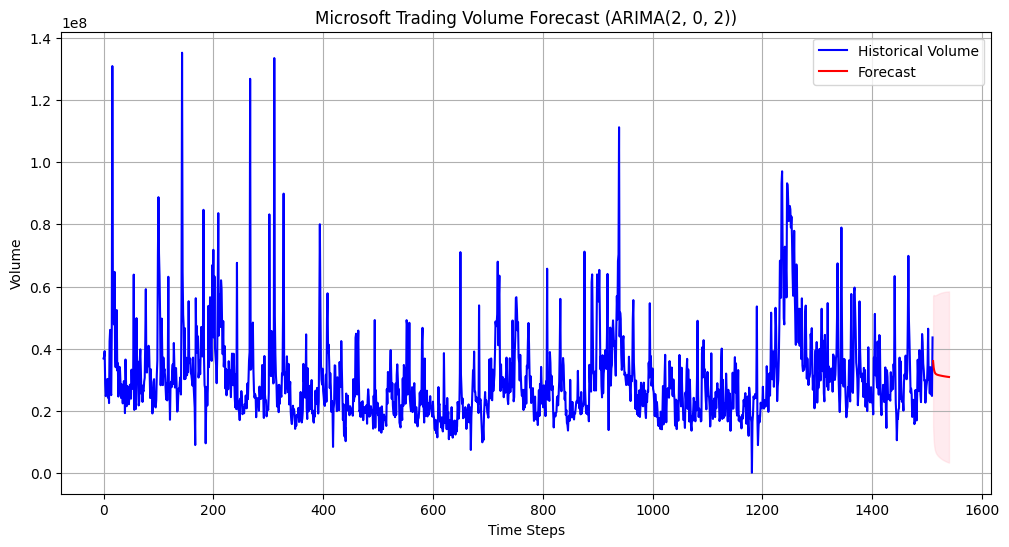

In [9]:
# Fit the best model
best_order = (2, 0, 2)
model = ARIMA(y, order=best_order)
model_fit = model.fit()

# Forecast the next 30 periods
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# Extract forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot historical data + forecast
plt.figure(figsize=(12,6))
plt.plot(y, label='Historical Volume', color='blue')
plt.plot(range(len(y), len(y) + forecast_steps), forecast_mean, label='Forecast', color='red')

# Confidence intervals
plt.fill_between(range(len(y), len(y) + forecast_steps),
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title(f'Microsoft Trading Volume Forecast (ARIMA{best_order})')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


now we split our data into teain/test, fit the ARIMAq(2,0,2) model on the train set, and then check predictions.

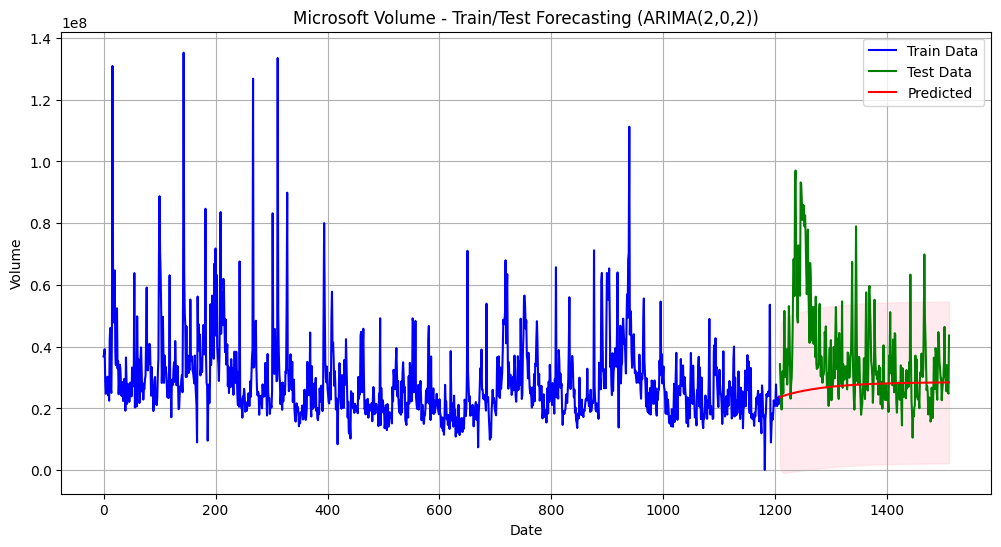

RMSE: 19114767.45
MAE: 12413155.28


In [10]:
# Train-Test Split
train_size = int(len(y) * 0.8)  # 80% train, 20% test
train, test = y[:train_size], y[train_size:]

#Fit ARIMA
model = ARIMA(train, order=(2, 0, 2))
model_fit = model.fit()

#Forecast same length as test
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

#Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, forecast_mean, label='Predicted', color='red')

# Confidence intervals
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Microsoft Volume - Train/Test Forecasting (ARIMA(2,0,2))')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#Accuracy Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast_mean)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


In [11]:
#Now, we compare errors to the average volume
avg_volume = y.mean()
rel_mae = (12413155.28 / avg_volume) * 100
rel_rmse = (19114767.45 / avg_volume) * 100
print(rel_mae, rel_rmse)

41.10503457206826 63.2968136743791
